# H-Entropy Search

In this tutorial, we show how to implement H-Entropy Search procedure [1] in a closed loop in BoTorch.

[1]: W. Neiswanger, L. Yu, S. Zhao, C. Meng, S. Ermon. Generalizing Bayesian Optimization with Decision-theoretic Entropies. Appears in Proceedings of the 36th Conference on Neural Information Processing Systems (NeurIPS 2022)

We will begin by importing several essential packages

In [1]:
import os
import random
import warnings
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import torch
from botorch import fit_gpytorch_model
from botorch.acquisition.hentropy_search import (
    qHEntropySearch, qLossFunctionTopK, qLossFunctionMinMax
)
from botorch.models import SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.test_functions.synthetic import Ackley
from gpytorch.mlls import ExactMarginalLogLikelihood

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In this tutorial, we will explore the 2D Ackley function within the range of [-1, 1]. Our objective is to accomplish two tasks: 1) finding the top-2 values, and 2) determining the min-max of the function. To facilitate the evaluation process, we will define the following functions:

In [2]:
def eval_and_plot(func, cfg, qhes, next_x, data, iteration):
    # Quality of the best decision from the current posterior distribution #############
    # Initialize A consistently across fantasies
    A = torch.rand(
        [1, 1, cfg.num_action, cfg.num_dim_action],
        requires_grad=True,
        device=cfg.device,
        dtype=cfg.dtype,
    )

    # Initialize optimizer
    optimizer = torch.optim.Adam([A], lr=cfg.acq_opt_lr)
    ba_l, ba_u = cfg.bounds_action

    for i in range(cfg.acq_opt_iter):
        A_ = A.permute(1, 0, 2, 3)
        A_ = torch.sigmoid(A_) * (ba_u - ba_l) + ba_l
        posterior = qhes.model.posterior(A_)
        fantasized_outcome = qhes.action_sampler(posterior)
        # >>> n_fantasy_at_action_pts x n_fantasy_at_design_pts
        # ... x batch_size x num_actions x 1

        fantasized_outcome = fantasized_outcome.squeeze(dim=-1)
        # >>> n_fantasy_at_action_pts x n_fantasy_at_design_pts
        # ... x batch_size x num_actions

        losses = -qhes.loss_function(A=A_, Y=fantasized_outcome)
        # >>> n_fantasy_at_design_pts x batch_size

        loss = losses.mean(dim=0).sum()
        A.grad = torch.autograd.grad(loss, A)[0]
        optimizer.step()
        optimizer.zero_grad()

        if i % 200 == 0:
            print(f"Eval optim round: {i}, Loss: {loss.item():.2f}")

    with torch.no_grad():
        A = torch.sigmoid(A) * (ba_u - ba_l) + ba_l
        eval_metric = qhes.loss_function(A=A, Y=fantasized_outcome)
        eval_metric = eval_metric[0, 0].cpu().detach().numpy()
        optimal_action = A[0, 0].cpu().detach().numpy()
        value = qhes.loss_function(A=A, Y=func(A))[0, 0].cpu().detach().numpy()
        data_x = data.x.cpu().detach().numpy()
        next_x = next_x.cpu().detach().numpy()

    # Plotting #########################################################################
    fig, ax = plt.subplots(1, 1)
    bounds_plot = cfg.bounds_design
    ax.set(xlabel="$x_1$", ylabel="$x_2$", xlim=bounds_plot, ylim=bounds_plot)
    title = r"$\mathcal{H}_{\ell, \mathcal{A}}$-Entropy Search " + cfg.task
    ax.set_title(label=title)

    # Plot function in 2D ##############################################################
    X_domain, Y_domain = cfg.bounds_design, cfg.bounds_design
    n_space = 200
    X, Y = np.linspace(*X_domain, n_space), np.linspace(*Y_domain, n_space)
    X, Y = np.meshgrid(X, Y)
    XY = torch.tensor(np.array([X, Y]))
    Z = func(XY.reshape(2, -1).T).reshape(X.shape)
    cs = ax.contourf(X, Y, Z, levels=30, cmap="bwr", alpha=0.7)
    ax.set_aspect(aspect="equal")
    cbar = fig.colorbar(cs)
    cbar.ax.set_ylabel("$f(x)$", rotation=270, labelpad=20)

    # Plot data, optimal actions, next query ###########################################
    ax.scatter(data_x[:, 0], data_x[:, 1], label="Data", c='k')
    ax.scatter(optimal_action[:, 0], optimal_action[:, 1], label="Action", c='b')
    ax.scatter(next_x[:, 0], next_x[:, 1], label="Next query", c='g')
    plt.legend()
    plt.show()
    plt.close()

    return eval_metric, optimal_action, value


def initialize_model(data, state_dict=None):
    model = SingleTaskGP(
        train_X=data.x,
        train_Y=data.y,
        outcome_transform=Standardize(1),
    ).to(data.x)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # load state dict if it is passed
    if state_dict is not None:
        model.load_state_dict(state_dict)

    return mll, model


We'll be running the BO loops twice to accomplish two tasks: finding the Min-Max and finding the top-k with k=2.

BO round: 0, Optim round: 0, Loss: 0.29
BO round: 0, Optim round: 200, Loss: -134.14
BO round: 0, Optim round: 400, Loss: -135.54
BO round: 0, Optim round: 600, Loss: -135.68
BO round: 0, Optim round: 800, Loss: -135.72
next_x = [-0.1, 0.96]
next_y = 2.86
Eval optim round: 0, Loss: -0.04
Eval optim round: 200, Loss: -1.04
Eval optim round: 400, Loss: -1.04
Eval optim round: 600, Loss: -1.04
Eval optim round: 800, Loss: -1.04


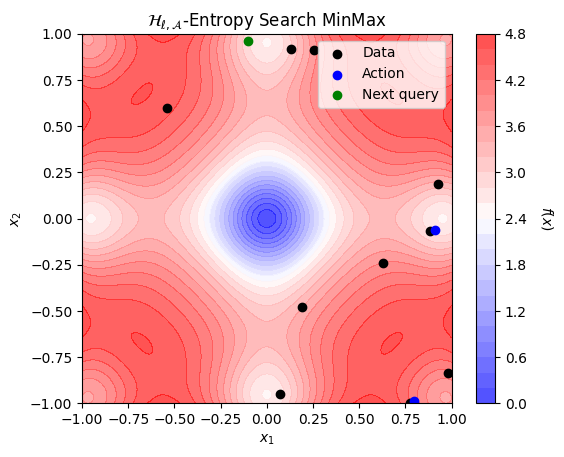

BO round: 1, Optim round: 0, Loss: 0.33
BO round: 1, Optim round: 200, Loss: -157.83
BO round: 1, Optim round: 400, Loss: -158.71
BO round: 1, Optim round: 600, Loss: -158.84
BO round: 1, Optim round: 800, Loss: -158.94
next_x = [-0.05, 0.63]
next_y = 3.29
Eval optim round: 0, Loss: -0.01
Eval optim round: 200, Loss: -1.47
Eval optim round: 400, Loss: -1.47
Eval optim round: 600, Loss: -1.47
Eval optim round: 800, Loss: -1.47


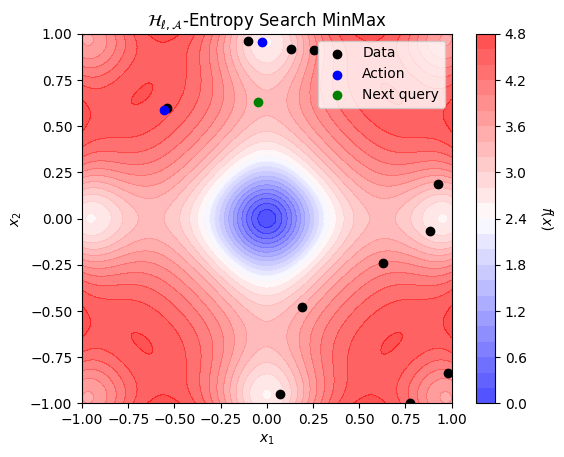

BO round: 0, Optim round: 0, Loss: -1311.93
BO round: 0, Optim round: 200, Loss: -2304.61
BO round: 0, Optim round: 400, Loss: -2320.98
BO round: 0, Optim round: 600, Loss: -2330.52
BO round: 0, Optim round: 800, Loss: -2331.72
next_x = [-0.57, 0.31]
next_y = 3.95
Eval optim round: 0, Loss: -11.16
Eval optim round: 200, Loss: -17.50
Eval optim round: 400, Loss: -17.76
Eval optim round: 600, Loss: -17.78
Eval optim round: 800, Loss: -17.78


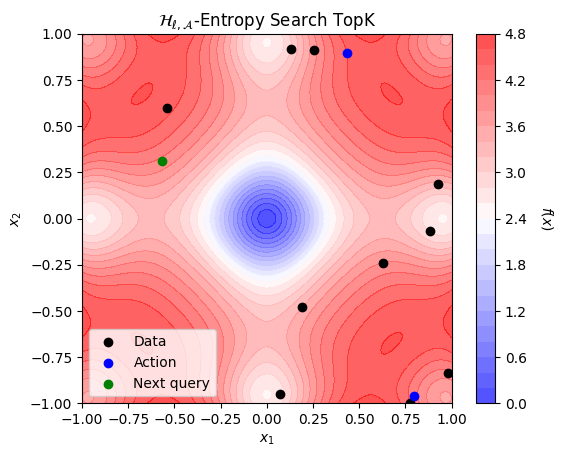

BO round: 1, Optim round: 0, Loss: -1304.26
BO round: 1, Optim round: 200, Loss: -2296.42
BO round: 1, Optim round: 400, Loss: -2317.83
BO round: 1, Optim round: 600, Loss: -2325.54
BO round: 1, Optim round: 800, Loss: -2326.25
next_x = [0.38, 0.12]
next_y = 2.83
Eval optim round: 0, Loss: -12.50
Eval optim round: 200, Loss: -17.92
Eval optim round: 400, Loss: -17.93
Eval optim round: 600, Loss: -17.93
Eval optim round: 800, Loss: -17.93


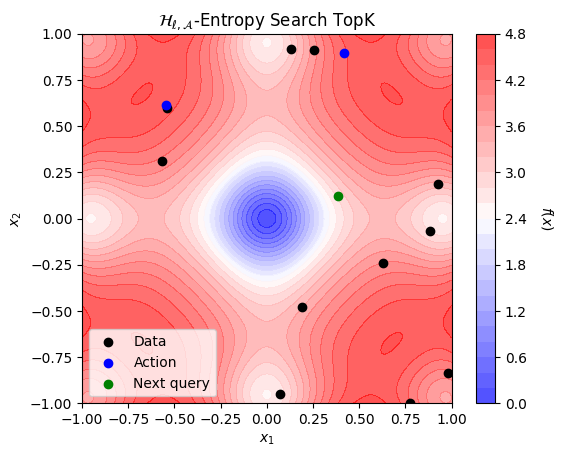

In [3]:
exps = [
    dict(
        task="MinMax",
        qLossFunction=qLossFunctionMinMax,
        loss_function_hyperparameters=dict(),
    ),
    dict(
        task="TopK",
        qLossFunction=qLossFunctionTopK,
        loss_function_hyperparameters=dict(
            dist_weight=10,
            dist_threshold=1,
        ),
    ),
]

n_fantasy_at_design_pts = 64 if not SMOKE_TEST else 2
n_fantasy_at_action_pts = 64 if not SMOKE_TEST else 2
num_restarts = 128 if not SMOKE_TEST else 4
acq_opt_iter = 1000 if not SMOKE_TEST else 10

for exp in exps:
    # We start to loop through 2 experiments with different loss functions: MinMax and TopK
    # We expect that after BO loops, we can find
    # - MinMax: two actions, one at minimum and one at maximum
    # - TopK: two actions that have output values in top-2
    
    # Configure hes trial
    cfg = Namespace(
        seed=10,
        num_iteration=2,
        num_initial_points=10,
        num_dim_design=2,
        num_dim_action=2,
        bounds_design=[-1, 1],
        bounds_action=[-1, 1],
        num_action=2,
        n_fantasy_at_design_pts=n_fantasy_at_design_pts,
        n_fantasy_at_action_pts=n_fantasy_at_action_pts,
        num_restarts=num_restarts,
        acq_opt_iter=acq_opt_iter,
        acq_opt_lr=0.05,
        num_candidates=1,
        func_is_noisy=False,
        func_noise=0.1,
        device="cuda:0" if torch.cuda.is_available() else "cpu",
        dtype=torch.double,
        loss_function_hyperparameters=exp["loss_function_hyperparameters"],
        task=exp["task"]
    )

    # Suppress potential optimization warnings for cleaner output
    warnings.filterwarnings("ignore")

    # Set random seeds
    np.random.seed(cfg.seed)
    random.seed(cfg.seed)
    torch.manual_seed(cfg.seed)
    torch.cuda.manual_seed_all(cfg.seed)
    # torch.backends.cudnn.deterministic=True
    # torch.backends.cudnn.benchmark = False

    bd_l, bd_u = cfg.bounds_design
    ba_l, ba_u = cfg.bounds_action
    f_ = Ackley(dim=cfg.num_dim_design, negate=False)
    f_.bounds[0, :].fill_(bd_l)
    f_.bounds[1, :].fill_(bd_u)
    f_ = f_.to(dtype=cfg.dtype, device=cfg.device)

    def func(x):
        return f_(x)[..., None]

    # Generate initial observations and initialize model
    data_x = torch.rand(
        [cfg.num_initial_points, cfg.num_dim_design], device=cfg.device, dtype=cfg.dtype
    )
    data_x = data_x * (bd_u - bd_l) + bd_l
    # >>> n x dim

    data_y = func(data_x)
    # >>> n x 1

    if cfg.func_is_noisy:
        data_y = data_y + cfg.func_noise * torch.randn_like(data_y)

    data = Namespace(x=data_x, y=data_y)

    mll, model = initialize_model(data)

    # Logging
    eval_list = []
    eval_data_list = []

    # Run BO loop
    for j in range(cfg.num_iteration):
        
        # Fit the model
        fit_gpytorch_model(mll)

        # Initialize X and A
        X = torch.rand(
            [cfg.num_restarts, cfg.num_candidates, cfg.num_dim_design],
            requires_grad=True,
            device=cfg.device,
            dtype=cfg.dtype,
        )

        A = torch.rand(
            [
                cfg.num_restarts,
                cfg.n_fantasy_at_design_pts,
                cfg.num_action,
                cfg.num_dim_action,
            ],
            requires_grad=True,
            device=cfg.device,
            dtype=cfg.dtype,
        )

        # define optimizer and objective function
        optimizer = torch.optim.Adam([X, A], lr=cfg.acq_opt_lr)
        qhes = qHEntropySearch(
            model=model,
            n_fantasy_at_design_pts=cfg.n_fantasy_at_design_pts,
            n_fantasy_at_action_pts=cfg.n_fantasy_at_action_pts,
            loss_function_class=exp["qLossFunction"],
            loss_function_hyperparameters=cfg.loss_function_hyperparameters,
        )
        for i in range(cfg.acq_opt_iter):
            loss = -qhes(
                X=torch.sigmoid(X) * (bd_u - bd_l) + bd_l,
                A=torch.sigmoid(A) * (ba_u - ba_l) + ba_l,
            ).sum()
            
            X.grad, A.grad = torch.autograd.grad(loss, [X, A])
            optimizer.step()
            optimizer.zero_grad()

            if i % 200 == 0:
                print(f"BO round: {j}, Optim round: {i}, Loss: {loss.item():.2f}")
                    
        # Get next query and observe the outcome
        X = torch.sigmoid(X) * (bd_u - bd_l) + bd_l
        A = torch.sigmoid(A) * (ba_u - ba_l) + ba_l
        best_id = qhes(X, A).argmax()
        next_x = X[best_id].cpu().detach()
        action_samples = A[best_id]
        next_y = func(next_x).cpu().detach()
        print(f"next_x = {[round(x, 2) for x in next_x.squeeze().numpy().tolist()]}")
        print(f"next_y = {next_y.squeeze().item():.2f}")

        # Evaluate and plot
        eval_metric, optimal_action, value = eval_and_plot(
            func=func, cfg=cfg, qhes=qhes, next_x=next_x, data=data, iteration=j
        )
        eval_list.append(eval_metric)
        eval_data_list.append(optimal_action)

        # Update training points
        data.x = torch.cat([data.x, next_x.to(cfg.device)])
        data.y = torch.cat([data.y, next_y.to(cfg.device)])

        # Re-initialize model for next iteration, use state_dict to speed up fitting
        mll, model = initialize_model(data, model.state_dict())
